# Visualizing Data using the Embedding Projector in TensorBoard

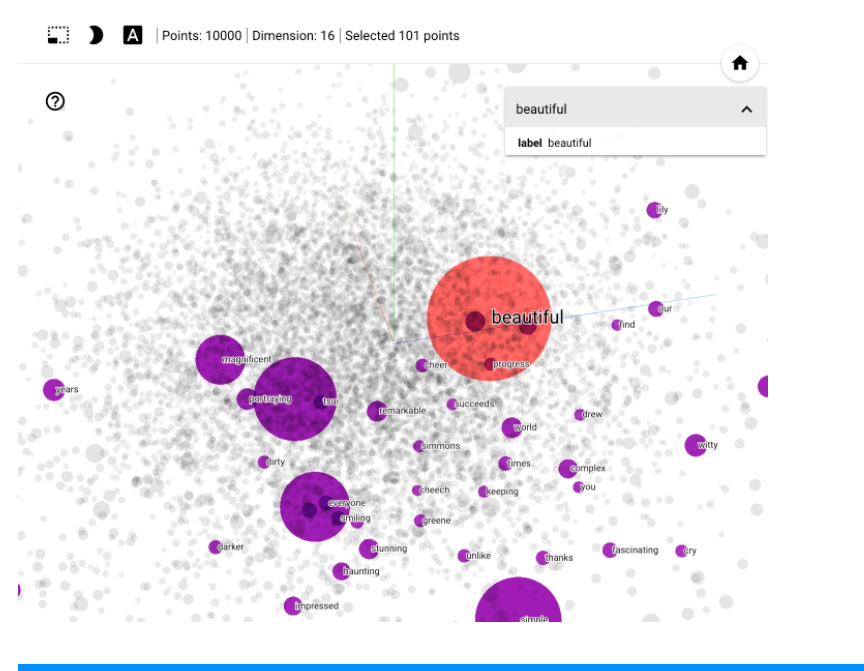

In [1]:
from IPython.display import Image, display
display(Image(filename="./image/visualizing.png", embed=True))

## 1. Setup

In [2]:
import os
import tensorflow as tf

# pip install -U tensorflow_datasets
import tensorflow_datasets as tfds

# pip install -U tensorflow_text
import tensorflow_text as text

from tensorboard.plugins import projector


print("The version of Tensorflow: {}".format(tf.__version__))

The version of Tensorflow: 2.4.1


## 2. IMDB Data

In [3]:
(train_data, test_data), info = tfds.load(
    "imdb_reviews/subwords8k",
    split=(tfds.Split.TRAIN, tfds.Split.TEST),
    with_info=True,
    as_supervised=True,
)

# WARNING:absl:TFDS datasets with text encoding are deprecated and will be removed in a future version. 
# Instead, you should use the plain text version and tokenize the text using `tensorflow_text` 
# (See: https://www.tensorflow.org/tutorials/tensorflow_text/intro#tfdata_example)
encoder = info.features["text"].encoder

# shuffle and pad the data.
train_batches = train_data.shuffle(1000).padded_batch(
    10, padded_shapes=((None,), ())
)
test_batches = test_data.shuffle(1000).padded_batch(
    10, padded_shapes=((None,), ())
)
train_batch, train_labels = next(iter(train_batches))

### Keras Embedding Layer

In [4]:
# Create an embedding layer
embedding_dim = 16
embedding = tf.keras.layers.Embedding(encoder.vocab_size, embedding_dim)
# Train this embedding as part of a keras model
model = tf.keras.Sequential(
    [
        embedding, # The embedding layer should be the first layer in a model.
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

# Compile model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Train model
history = model.fit(
    train_batches, epochs=1, validation_data=test_batches, validation_steps=20
)

2500/2500 [==============================] - 12s 4ms/step - loss: 0.6036 - accuracy: 0.5936 - val_loss: 0.3458 - val_accuracy: 0.8350


## 3. Saving data for TensorBoard

In [5]:
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='./logs/imdb-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
# 这是在文件写入的时候报的错误，而万恶的 windows 打开文件默认是以“gbk“编码的，
# 可能造成不识别unicode字符，于是做了如下的修改：
with open(os.path.join(log_dir, 'metadata.tsv'), "w", encoding="utf-8") as f:
  for subwords in encoder.subwords:
    f.write("{}\n".format(subwords))
  # Fill in the rest of the labels with "unknown"
  for unknown in range(1, encoder.vocab_size - len(encoder.subwords)):
    f.write("unknown #{}\n".format(unknown))


# Save the weights we want to analyse as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, so
# we will remove that value.
weights = tf.Variable(model.layers[0].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

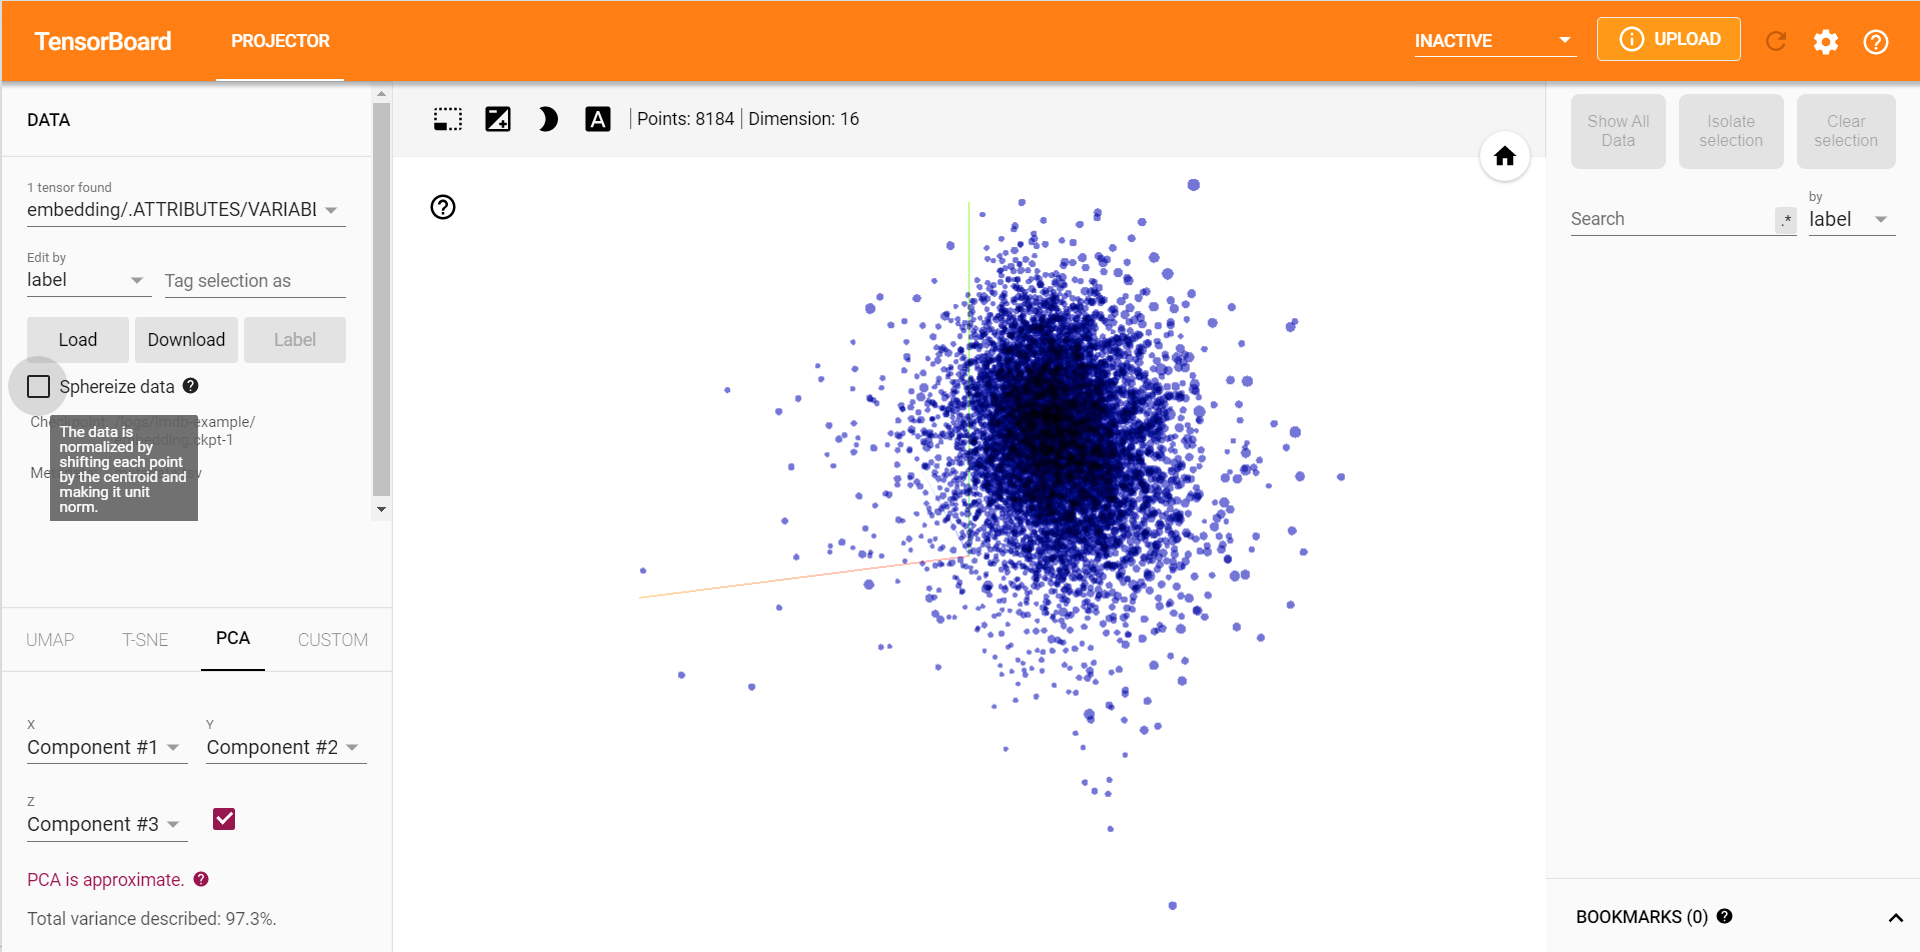

In [9]:
from IPython.display import Image, display
display(Image(filename="./image/visualizing1.png", embed=True))

## 4. Analysis

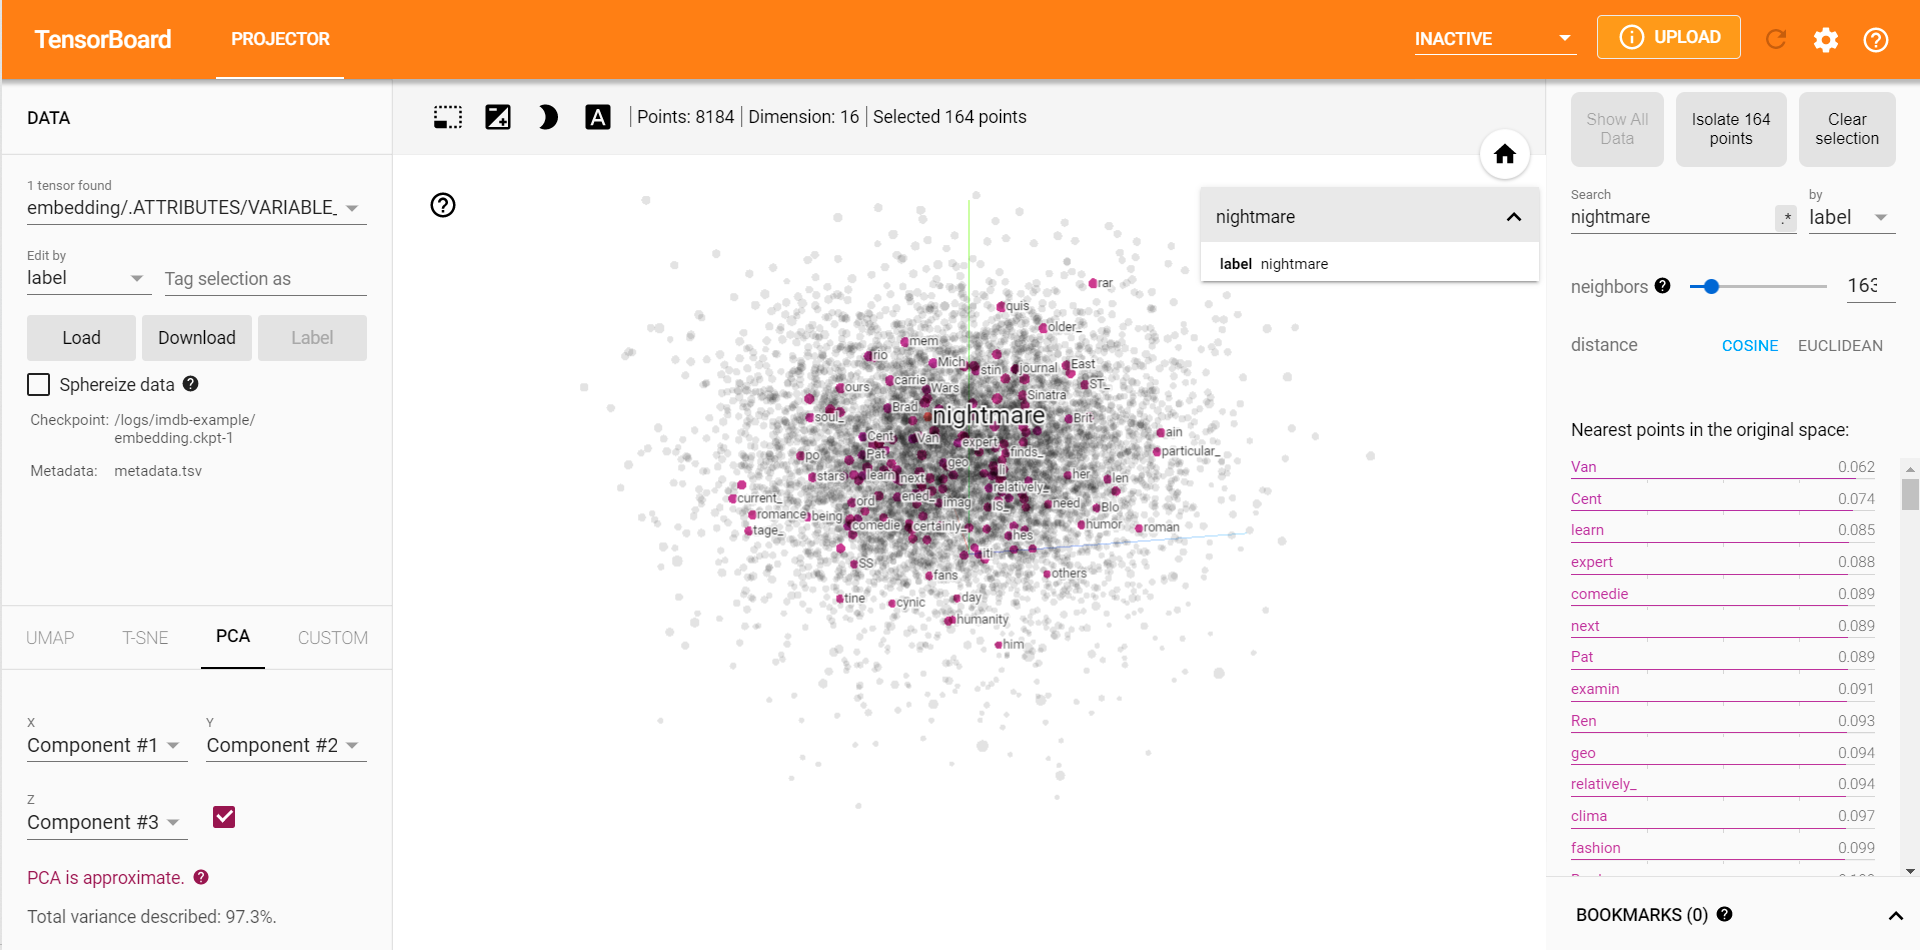

In [11]:
from IPython.display import Image, display
display(Image(filename="./image/visualizing2.png", embed=True))

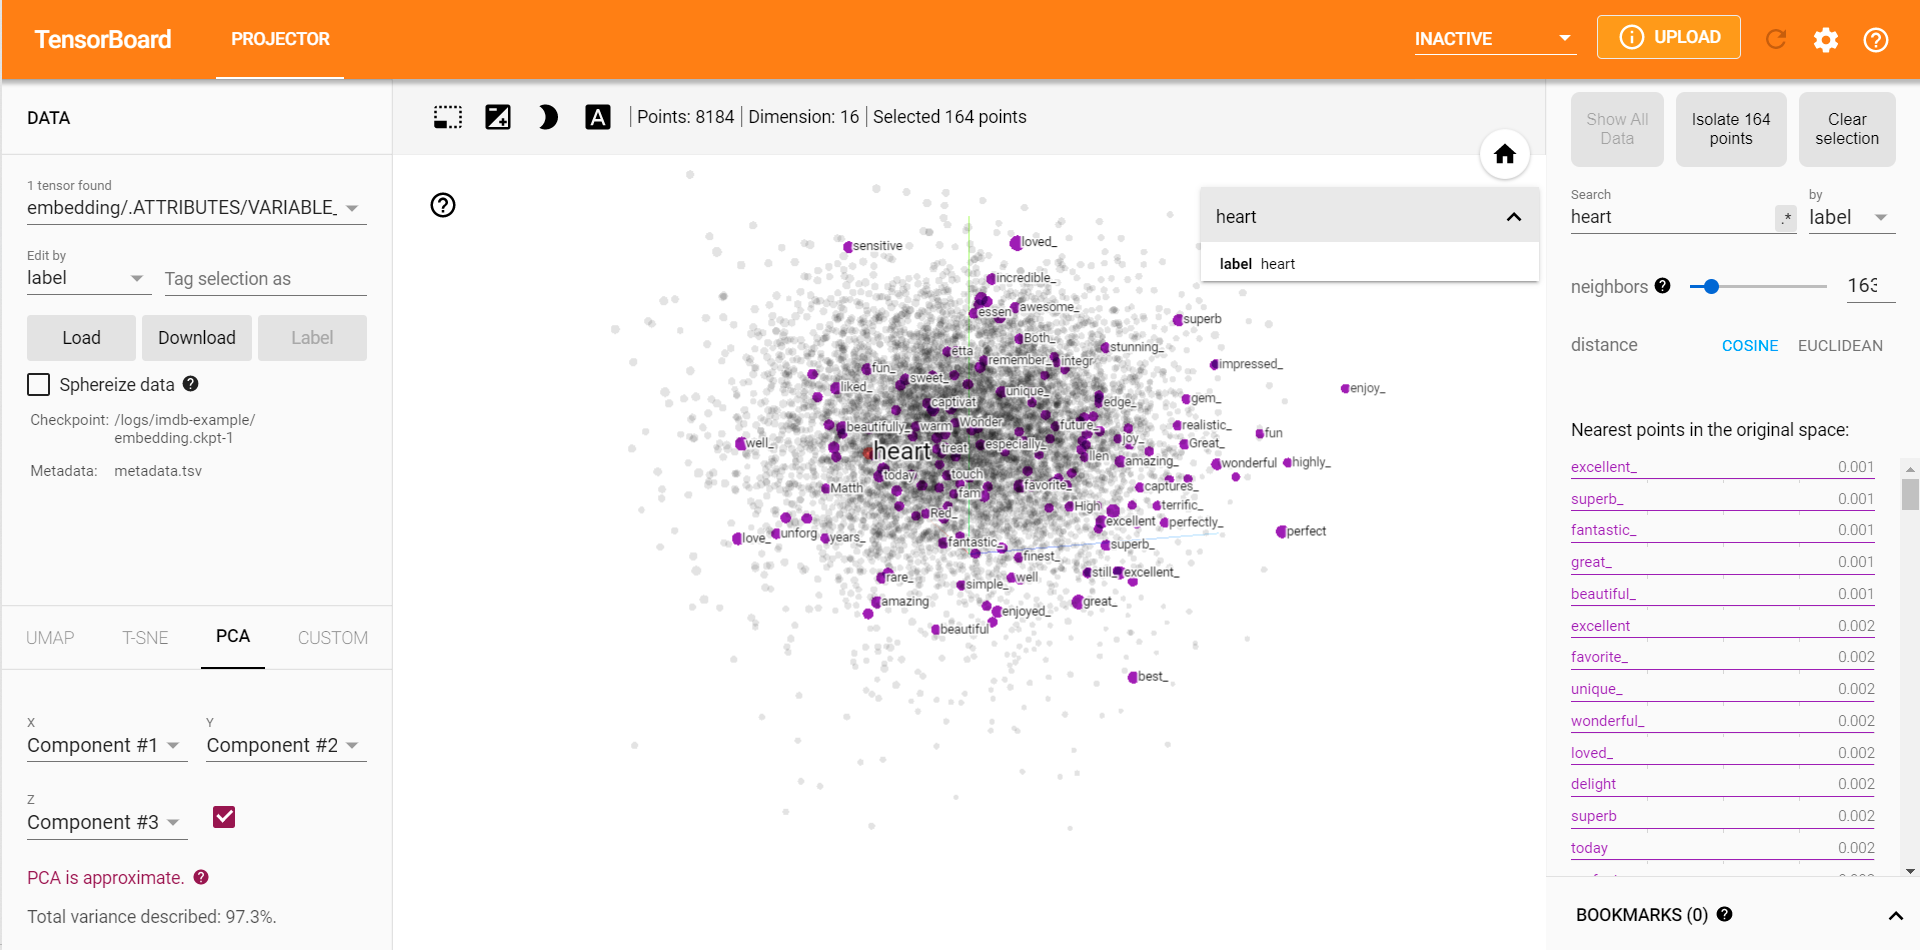

In [12]:
from IPython.display import Image, display
display(Image(filename="./image/visualizing3.png", embed=True))

# reference

### https://tensorflow.google.cn/tensorboard/tensorboard_projector_plugin